<h1 style="color:DarkOliveGreen;"> Rainfall Prediction </h1>

<h2 style="color:Peru;"> Problem Statement </h2>

**This dataset contains about 10 years of daily weather observations from many locations across Australia.**

**RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.**

<h2 style="color:Peru;"> Import Required Libraries </h2>

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,roc_auc_score,cohen_kappa_score,f1_score,confusion_matrix,classification_report,plot_roc_curve

import time
import pickle
from collections import Counter

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

<h2 style="color:Peru;"> Loading Dataset </h2>

In [2]:
df = pd.read_csv('./weatherAUS.csv')

In [3]:
# lets check the shape of dataset
df.shape

(145460, 23)

In [4]:
# Lets check the first five rows of dataset
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
# Let's get an overview of features datatype
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [6]:
# Lets check the missing values if any
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

We can clearly see that there are lots of missing values in a dataset which we'll have to fill or drop to start the further analysis.

<h2 style="color:Peru;"> EDA & Data Cleaning </h2>

**Analysis of Target Feature**

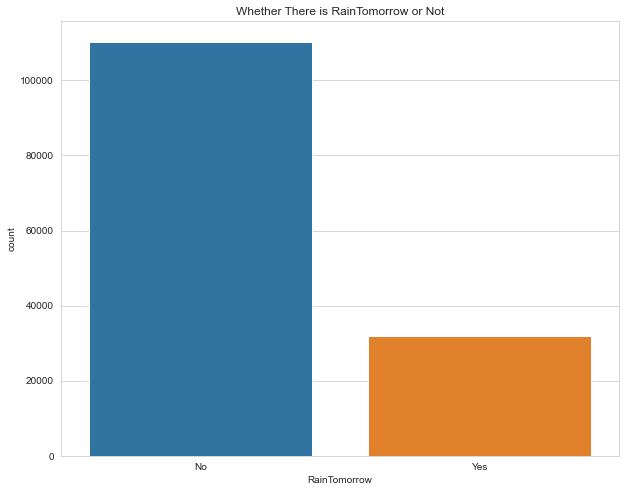

In [7]:
plt.figure(figsize=(10,8))
sns.countplot(df['RainTomorrow'])
plt.title('Whether There is RainTomorrow or Not')
plt.show()

**Analysis of Continuous Features**

In [8]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_features = [feature for feature in numerical_features if len(df[feature].unique())<25]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
categorical_features = [feature for feature in df.columns if feature not in numerical_features]
binary_categorical_features = [feature for feature in categorical_features if len(df[feature].unique()) <=3]
print("Numerical Features Count {}".format(len(numerical_features)))
print("Discrete features Count {}".format(len(discrete_features)))
print("Continuous features Count {}".format(len(continuous_features)))
print("Categorical features Count {}".format(len(categorical_features)))
print("Binary Categorical features Count {}".format(len(binary_categorical_features)))

Numerical Features Count 16
Discrete features Count 2
Continuous features Count 14
Categorical features Count 7
Binary Categorical features Count 2


In [9]:
def generate_distribution_plot(df, continuous_features):
    # create copy of dataframe
    data = df[continuous_features].copy()
    # Create subplots 
    fig, axes = plt.subplots(nrows=len(data.columns)//2, ncols=2,figsize=(15,20))
    fig.subplots_adjust(hspace=0.7)
    
    # set fontdict
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
    # Generate distplot
    for ax, feature in zip(axes.flatten(), data.columns):
        sns.distplot(data[feature],ax=ax)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
    plt.show()

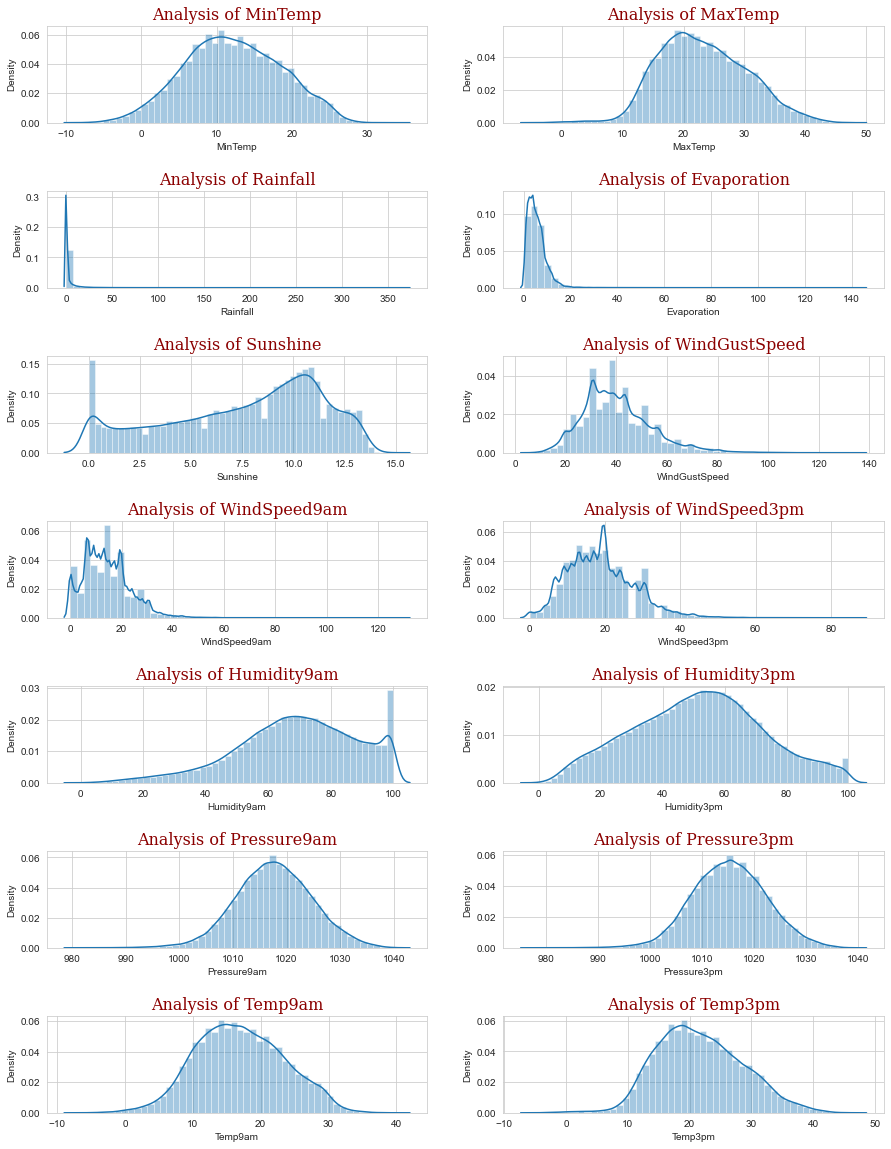

In [10]:
generate_distribution_plot(df, continuous_features)

In [11]:
sample_imputation_features = [col for col in df.columns if (df.isnull().sum()[col] > 50000)]

In [12]:
# Random Sampling for high number of missing values features-
def randomsampleimputation(df, columns):
    data = df.copy()
    for column in columns:
        random_sample = data[column].dropna().sample(data[column].isnull().sum(),random_state=2022)
        random_sample.index = data[data[column].isnull()].index
        data.loc[data[column].isnull(),column] = random_sample
    return data

In [13]:
df = randomsampleimputation(df,sample_imputation_features)

In [14]:
# list of numeric features with null values 
missing_values_numeric_features  = [col for col in df.columns if (df.isnull().sum()[col] > 0) & (df[col].dtypes != 'object')]

In [15]:
# Filling the Missing Values – Imputation
# Filling the missing data with the mean value for a numerical variable


# function for missing values substitution
def impute_means(df, missing_values_columns):
    data = df.copy()
    '''Filling missing values with mean'''
    for col in missing_values_columns:
        data[col] = data[col].fillna(data[col].mean())
        
    return data

In [16]:
# lets use this function to fill the missing values
df = impute_means(df,missing_values_numeric_features)

In [17]:
# checking the missing values again
df.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation          0
Sunshine             0
WindGustDir      10326
WindGustSpeed        0
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             0
Temp9am              0
Temp3pm              0
RainToday         3261
RainTomorrow      3267
dtype: int64

**OnehotEncoding handles categorical features null values very cleverly so we will use get_dummies function from pandas to handle null values and convert the data into proper format to use machine learning model.**

In [18]:
# sns.pairplot( data=df, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )
# plt.show()

In [19]:
def plot_boxplot(df, continuous_features):
    # create copy of dataframe
    data = df[continuous_features].copy()
    # Create subplots 
    fig, axes = plt.subplots(nrows=len(data.columns)//2, ncols=2,figsize=(15,20))
    fig.subplots_adjust(hspace=0.7)
    
    # set fontdict
    font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 16,
        }
    
    # Generate distplot
    for ax, feature in zip(axes.flatten(), data.columns):
        sns.boxplot(data[feature],ax=ax)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
    plt.show()

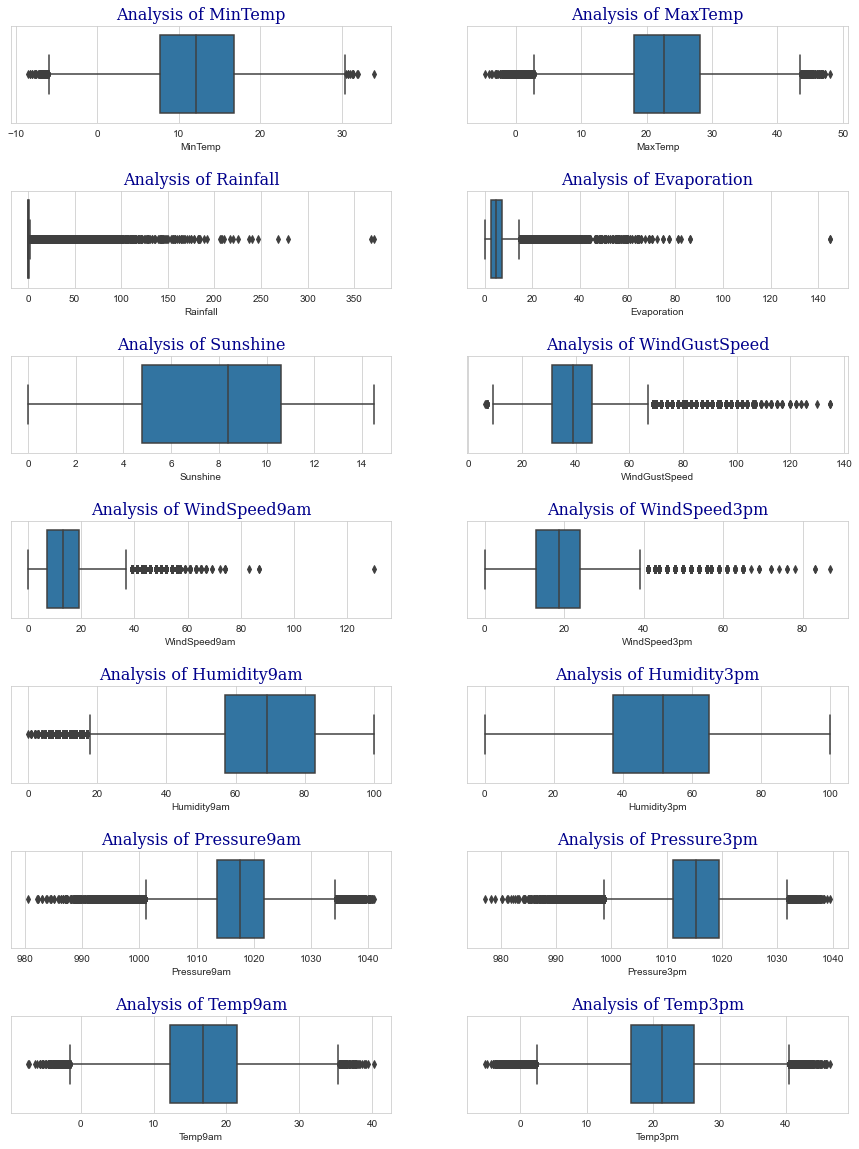

In [20]:
plot_boxplot(df, continuous_features)

In [21]:
outliers_features = [feature for feature in continuous_features if feature not in ['Sunshine','Humidity3pm']]
print(outliers_features)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


In [22]:
def remove_outliers(df,outliers_features):
    # create copy of dataframe
    
    data = df.copy()
    
    for feature in data[outliers_features].columns:
        Q3 = data[feature].quantile(0.75)
        Q1 = data[feature].quantile(0.25)
        IQR = Q3 - Q1
        lower_limit = round(Q1 - 1.5 * IQR)
        upper_limit = round(Q3 + 1.5 * IQR)
        data.loc[data[feature]>= upper_limit,feature] = upper_limit
        data.loc[data[feature]<=lower_limit,feature] = lower_limit
#         data = data[(data[feature] < upper_limit) & (data[feature] > lower_limit)]
    return data

In [23]:
df = remove_outliers(df,outliers_features)

In [24]:
df.shape

(145460, 23)

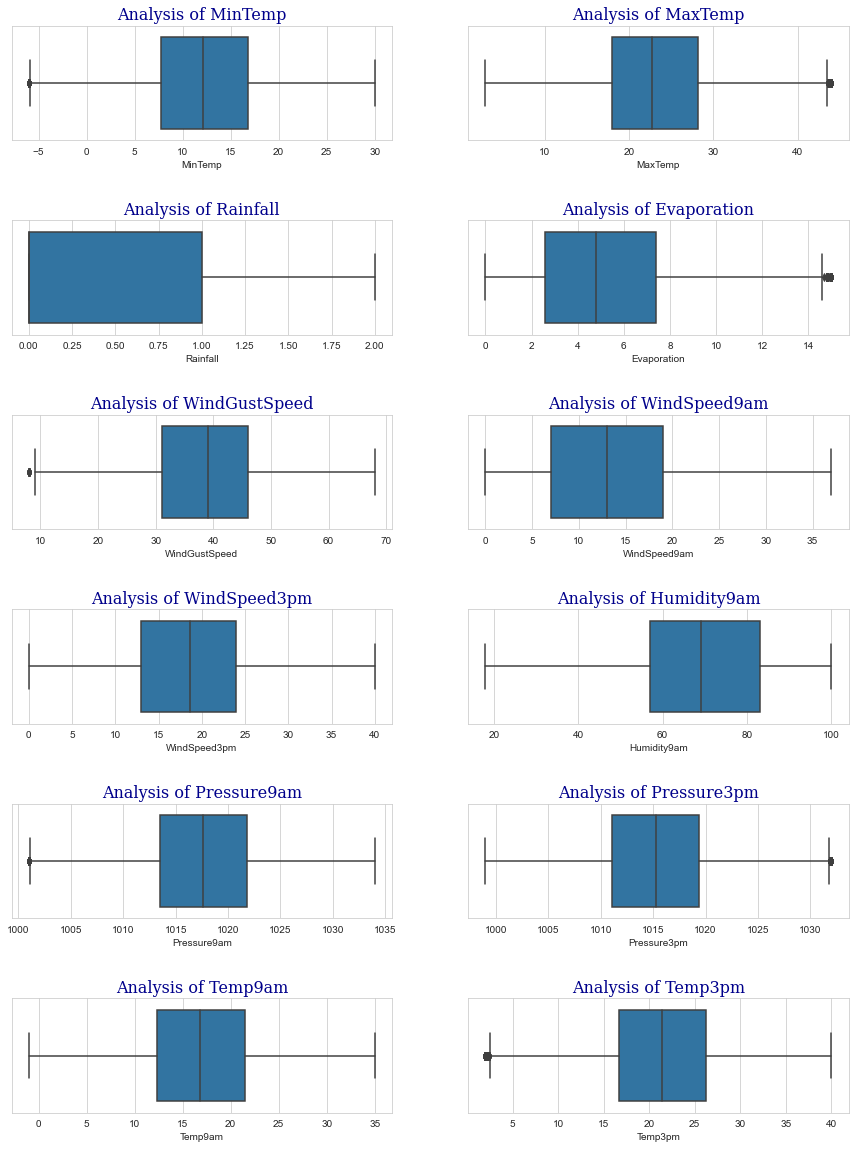

In [25]:
plot_boxplot(df, outliers_features)

In [26]:
# Raintoday
df['RainToday'] = df['RainToday'].fillna('No')
# Raintomorrow
df['RainTomorrow'] = df['RainTomorrow'].fillna('No')

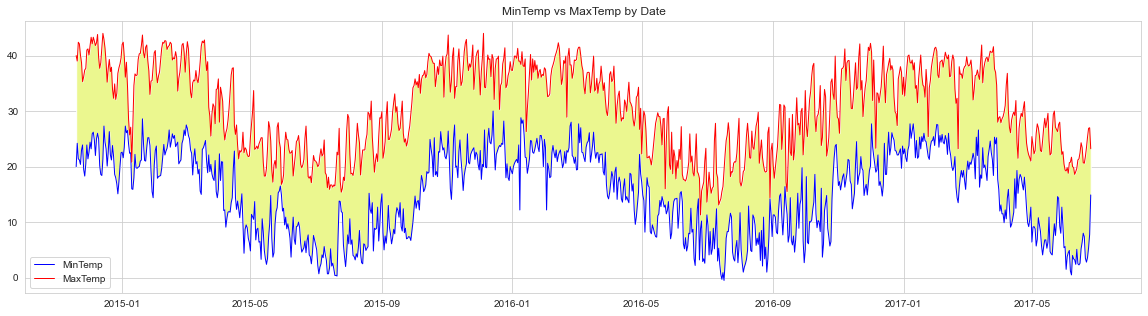

In [27]:
df["Date"] = pd.to_datetime(df["Date"])
# using data from last 3 years.
df_last_3_years = df.iloc[-950:,:]
plt.figure(figsize=[20,5])
plt.plot(df_last_3_years['Date'],df_last_3_years['MinTemp'],color='blue',linewidth=1, label= 'MinTemp')
plt.plot(df_last_3_years['Date'],df_last_3_years['MaxTemp'],color='red',linewidth=1, label= 'MaxTemp')
plt.fill_between(df_last_3_years['Date'],df_last_3_years['MinTemp'],df_last_3_years['MaxTemp'], facecolor = '#EBF78F')
plt.title('MinTemp vs MaxTemp by Date')
plt.legend(loc='lower left')
plt.show()

- Above plot shows that the MinTemp and MaxTemp relatively increases and decreases every year. As you can see that, December to February is summer; March to May is autumn; June to August is winter; and September to November is spring.
- The weather conditions are always opposite in the two hemispheres. As, the Australia is situated in the southern hemisphere. The seasons are bit different.


### **Handling DateTime Feature**

In [28]:
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day

# We don't need date feature anymore for model building
df.drop('Date', axis=1, inplace=True)

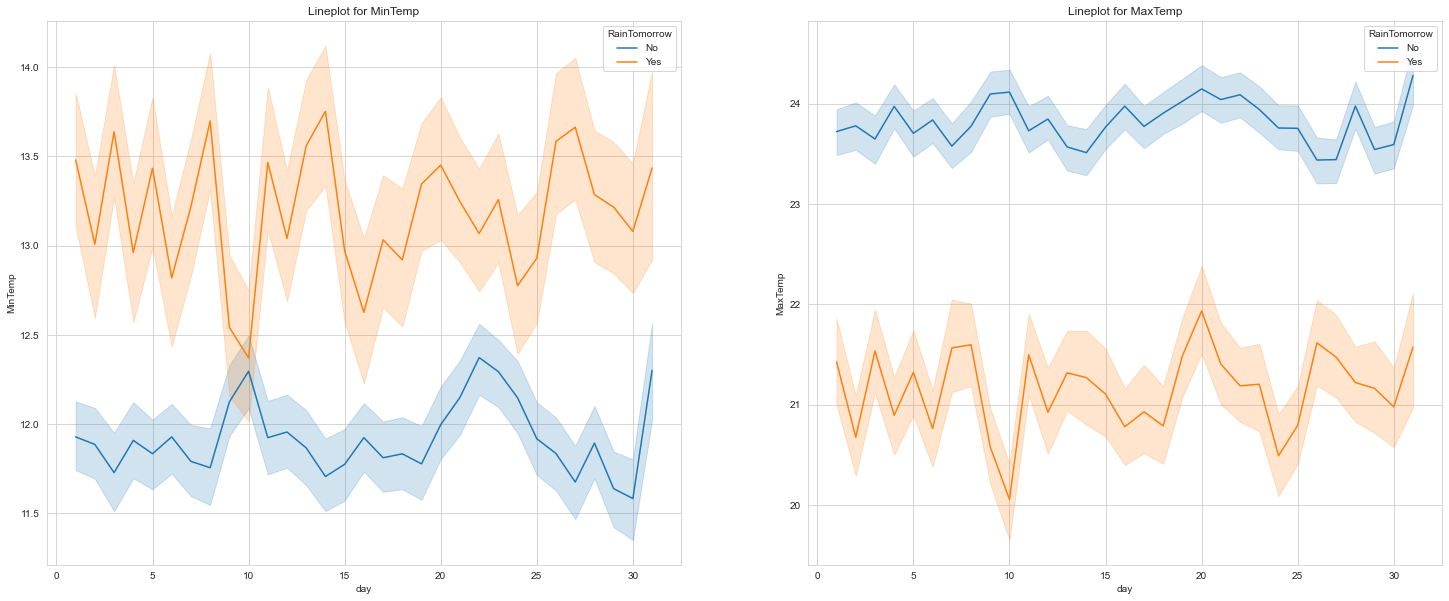

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Mintemp
sns.lineplot(ax=axes[0],x="day",y="MinTemp",hue="RainTomorrow",data=df)
axes[0].set_title('Lineplot for MinTemp')
# Maxtemp
sns.lineplot(ax=axes[1],x="day",y="MaxTemp",hue="RainTomorrow",data=df)
axes[1].set_title('Lineplot for MaxTemp')
plt.show()

If temperature difference between min and max temperature is low then probality of rain occuring tomorrow is more.

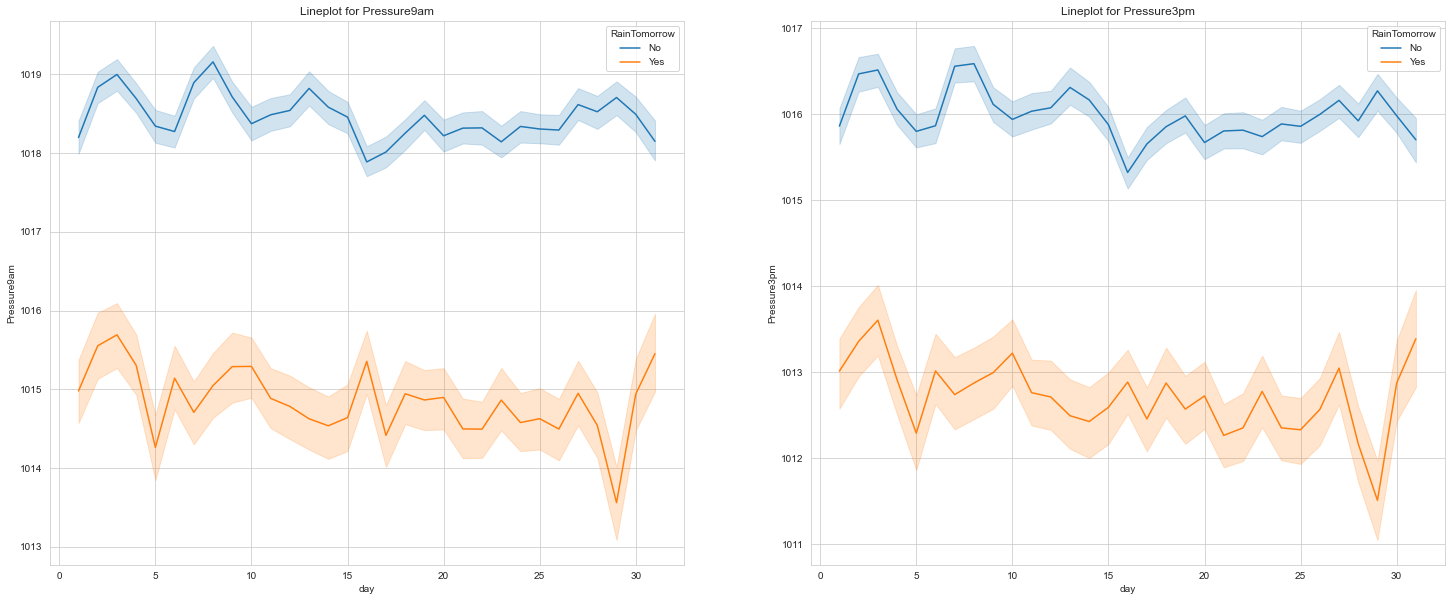

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Pressure9am
sns.lineplot(ax=axes[0],x="day",y="Pressure9am",hue="RainTomorrow",data=df)
axes[0].set_title('Lineplot for Pressure9am')
# Pressure3pm
sns.lineplot(ax=axes[1],x="day",y="Pressure3pm",hue="RainTomorrow",data=df)
axes[1].set_title('Lineplot for Pressure3pm')
plt.show()

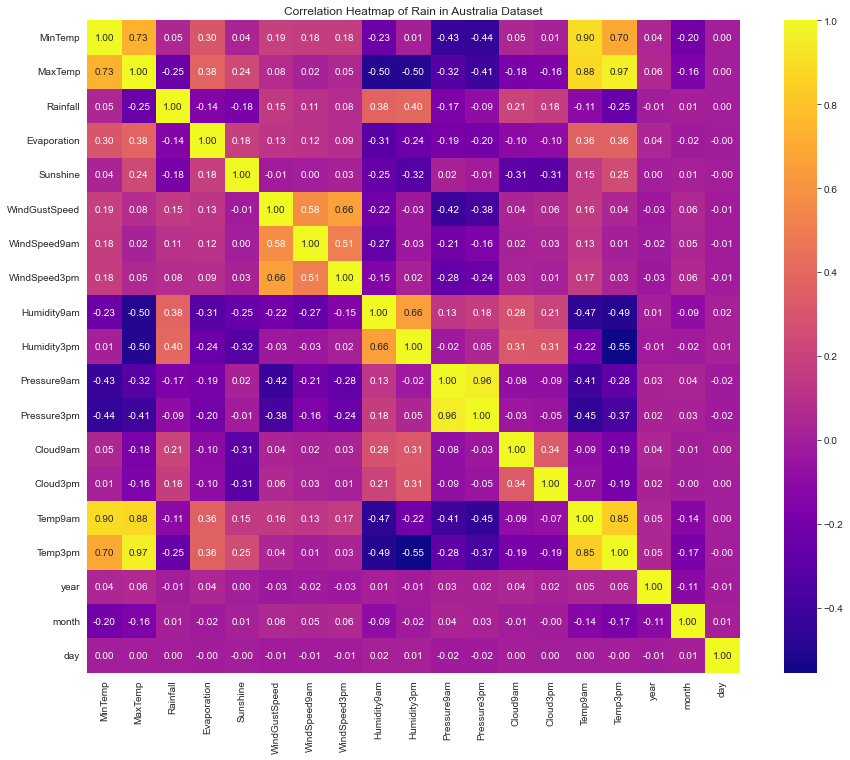

In [31]:
# lets check correlation again
corrmat = df.corr()

# heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', linecolor='white', cmap='plasma')    
plt.title('Correlation Heatmap of Rain in Australia Dataset')
plt.show()

Interpretation

From the above correlation heatmap, we can conclude that:-

    - MinTemp and MaxTemp variables are highly positively correlated (correlation coefficient = 0.73).

    - MinTemp and Temp3pm variables are also highly positively correlated (correlation coefficient = 0.70).

    - MinTemp and Temp9am variables are strongly positively correlated (correlation coefficient = 0.90).

    - MaxTemp and Temp9am variables are strongly positively correlated (correlation coefficient = 0.88).

    - MaxTemp and Temp3pm variables are also strongly positively correlated (correlation coefficient = 0.97).

    - WindGustSpeed and WindSpeed3pm variables are highly positively correlated (correlation coefficient = 0.66).

    - Pressure9am and Pressure3pm variables are strongly positively correlated (correlation coefficient = 0.96).
    
    - Temp9am and Temp3pm variables are strongly positively correlated (correlation coefficient = 0.85).                                 

<h2 style="color:Peru;"> Feature Engineering </h2>

In [32]:
# features_to_be_dropped = ['Temp9am','Temp3pm','Pressure3pm']
# df.drop(features_to_be_dropped,inplace= True,axis=1)

### **LabelEncoding For Binary Features**

In [33]:
# For binary features, we'll use labelencoding
le = LabelEncoder()

label_encoder_features = binary_categorical_features

for col in label_encoder_features:
    df[col] = le.fit_transform(df[col])

In [34]:
# let's check the head again
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,3.2,9.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,8.0,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,3.0,10.8,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,4.0,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,8.0,10.1,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,2008,12,3
3,Albury,9.2,28.0,0.0,15.0,6.1,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,3.0,18.1,26.5,0,0,2008,12,4
4,Albury,17.5,32.3,1.0,9.0,8.5,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,2008,12,5


### **OneHotEncoding for Categorical Features**

In [35]:
# creating list of categorical columns for one hot encoding
categorical_columns = [col for col in df.columns if df.dtypes[col] == 'object']
print('Categorical Features are : ',categorical_columns)

Categorical Features are :  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [36]:
# one hot encoding function for categorical features 
def onehot_encoder(df, cols):
    data = df.copy()
    for col in cols:
        dummies = pd.get_dummies(data[col],drop_first=True,prefix=col)
        # concatenating dummies and original dataframe
        data = pd.concat([data, dummies], axis=1)
        
        # dropping original columns for which encoding is applied.
        data.drop(col, axis=1,inplace=True)
    return data


In [37]:
# Apply onehotencoder on categorical features
df = onehot_encoder(df,categorical_columns)

In [38]:
# Dataframe shape after data preprocessing
df.shape

(145460, 114)

In [39]:
# first five rows of dataframe
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,3.2,9.9,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,8.0,16.9,21.8,0,0,2008,12,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,3.0,10.8,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,4.0,17.2,24.3,0,0,2008,12,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,8.0,10.1,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,2008,12,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,15.0,6.1,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,3.0,18.1,26.5,0,0,2008,12,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,9.0,8.5,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,2008,12,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [40]:
# Now,lets check missing values again
df.isnull().sum().sum()

0

<h2 style="color:Peru;"> Model Building </h2>

In [41]:
# splitting the data into X and y
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

In [42]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [43]:
# Scaling Numerical Features - Imbalanced data

scaler = RobustScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [44]:
# oversampling using SMOTE
sm = SMOTE(random_state=2022)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_sm)))

The number of classes before fit Counter({0: 90889, 1: 25479})
The number of classes after fit Counter({1: 90889, 0: 90889})


In [45]:
X_train_sm.shape

(181778, 113)

### **Model Selection**

In [45]:
def NeuralNetwork(num_features=X.shape[1], hidden_layer_sizes=(16, 8)):
    # Adding Input layer
    inputs = Input(shape=(num_features,))
    # Adding dense layer
    x = Dense(hidden_layer_sizes[0], activation='relu')(inputs)
    # Adding dense layer again
    x = Dense(hidden_layer_sizes[1], activation='relu')(x)
    # Adding output layer
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [46]:
# Models
models = [ LogisticRegression(solver='liblinear',penalty='l1'),
           RandomForestClassifier(max_depth=16,min_samples_leaf= 1,min_samples_split= 2,n_estimators= 200,random_state=2022),
           XGBClassifier(n_estimators=200, max_depth=15),
           CatBoostClassifier(iterations=2000, eval_metric = "AUC",verbose=0),
           NeuralNetwork()]

model_names=['Logistic Regression','Random Forest','XGBoost','CatBoost','Neural Network']

In [47]:
def build_models(models, model_names):
    # lets create an empty lists to append the results
    roc_auc_scores  = []
    cohens_kappa_scores = []
    time_taken_by_model = []
    results = {}
    
    # use enumerate() and zip() function to iterate the lists
    for idx, (ml_model_names, ml_models) in enumerate(zip(model_names, models)):
        if ml_model_names == 'Neural Network':
            t0 = time.time()
            nn_model = models[idx]
            history = nn_model.fit(X_train_sm,
                                y_train_sm,
                                validation_split=0.2,
                                epochs=10,
                                batch_size=32,
                                verbose=0
                                )
            predictions_nn = nn_model.predict(X_test)
            y_pred_nn = list(map(lambda x: np.argmax(x), predictions_nn))
            roc_auc_scores.append(roc_auc_score(y_test, y_pred_nn))
            cohens_kappa_scores.append(cohen_kappa_score(y_test, y_pred_nn))
            time_taken = time.time()-t0
            time_taken_by_model.append(time_taken)
        else:
            t0 = time.time()
            clf = models[idx]
            clf.fit(X_train_sm,y_train_sm)
            y_pred = clf.predict(X_test)
            roc_auc_scores.append(roc_auc_score(y_test, y_pred, average=None))
            cohens_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
            time_taken = time.time()-t0
            time_taken_by_model.append(time_taken)
            
    results = {'Model':model_names,
           'ROC_AUC_Score':roc_auc_scores,
           'Cohen_Kappa':cohens_kappa_scores,
           'Time Taken':time_taken_by_model}
    
    # Put the roc_auc_scores and cohens kappa scores in a data frame.
    models_scores_df = pd.DataFrame(results)
    return models_scores_df

In [48]:
models_scores_df = build_models(models, model_names)

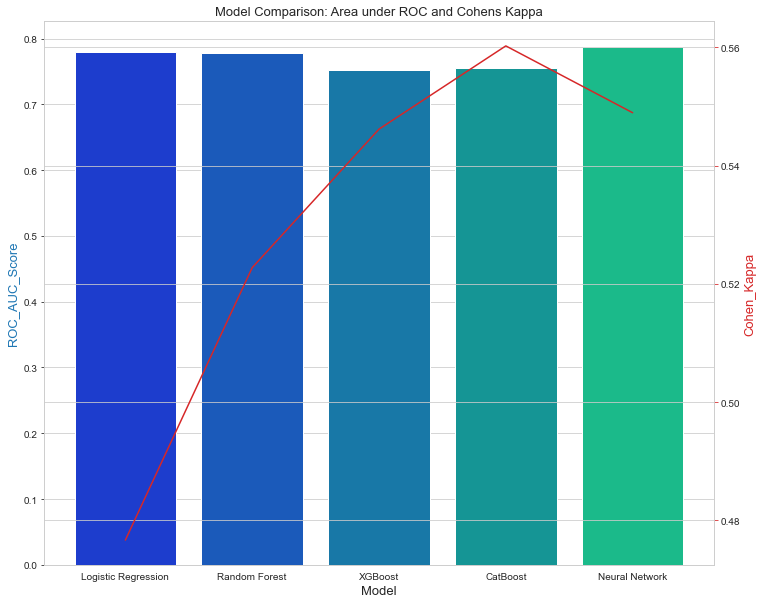

In [49]:
fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='ROC_AUC_Score', data = models_scores_df, palette='winter')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax3 = sns.lineplot(x='Model', y='Cohen_Kappa', data = models_scores_df, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

### **Model Training**

<h4 style="color:Brown;"> CatBoost </h4>

In [50]:
cat_sm = CatBoostClassifier(iterations=2000, eval_metric = "AUC",verbose=0)
cat_sm.fit(X_train_sm, y_train_sm,verbose=0)

In [51]:
y_pred_cat = cat_sm.predict(X_test)
print(confusion_matrix(y_test,y_pred_cat))
print(accuracy_score(y_test,y_pred_cat))
print(classification_report(y_test,y_pred_cat))

[[21467  1227]
 [ 2780  3618]]
0.862264540079747
              precision    recall  f1-score   support

           0       0.89      0.95      0.91     22694
           1       0.75      0.57      0.64      6398

    accuracy                           0.86     29092
   macro avg       0.82      0.76      0.78     29092
weighted avg       0.85      0.86      0.86     29092



0.7557110305329454

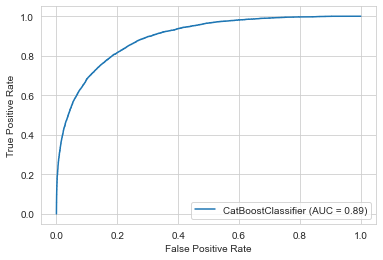

In [52]:
plot_roc_curve(cat_sm, X_test, y_test)
roc_auc_score(y_test, y_pred_cat, average=None) 

In [53]:
def make_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    categories = ['No','Yes']


    sns.heatmap(cm, annot=labels, fmt='',xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

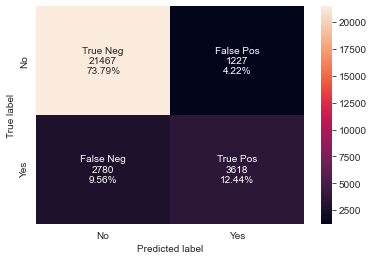

In [54]:
make_confusion_matrix(y_test, y_pred_cat)

In [55]:
# saving model
def save_model(model, directory_name, file_name):
    '''Check if directory exists, if not, create it'''
    CHECK_FOLDER = os.path.isdir(directory_name)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(directory_name)
        print("created folder : ", directory_name)
        filepath = os.path.join(directory_name, file_name)
        # save the model to disk
        pickle.dump(model, open(filepath, 'wb'))
        print("File Saved Successfully")

    else:
        print(directory_name, "folder already exists.")
        filepath = os.path.join(directory_name, file_name)
        # save the model to disk
        pickle.dump(model, open(filepath, 'wb'))
        print("File Saved Successfully")

# Apply function save_model to save the model
save_model(cat_sm,'Model','catboost_sm.pkl')

created folder :  Model
File Saved Successfully


<h4 style="color:Brown;"> Neural Network </h4>

In [56]:
# Apply NeuralNetwork
model_nn = NeuralNetwork()

In [57]:
# checking model summary
model_nn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 113)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1824      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
Total params: 1,978
Trainable params: 1,978
Non-trainable params: 0
_________________________________________________________________


In [58]:
EPOCHS = 10
BATCH_SIZE = 32 
# model fit
history = model_nn.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
2910/2910 [==============================] - 10s 3ms/step - loss: 0.3693 - accuracy: 0.8396 - val_loss: 0.3485 - val_accuracy: 0.8500
Epoch 2/10
2910/2910 [==============================] - 8s 3ms/step - loss: 0.3430 - accuracy: 0.8535 - val_loss: 0.3411 - val_accuracy: 0.8546
Epoch 3/10
2910/2910 [==============================] - 6s 2ms/step - loss: 0.3351 - accuracy: 0.8563 - val_loss: 0.3344 - val_accuracy: 0.8587
Epoch 4/10
2910/2910 [==============================] - 10s 3ms/step - loss: 0.3294 - accuracy: 0.8587 - val_loss: 0.3323 - val_accuracy: 0.8576
Epoch 5/10
2910/2910 [==============================] - 9s 3ms/step - loss: 0.3255 - accuracy: 0.8597 - val_loss: 0.3350 - val_accuracy: 0.8564
Epoch 6/10
2910/2910 [==============================] - 8s 3ms/step - loss: 0.3226 - accuracy: 0.8609 - val_loss: 0.3295 - val_accuracy: 0.8582
Epoch 7/10
2910/2910 [==============================] - 7s 3ms/step - loss: 0.3203 - accuracy: 0.8618 - val_loss: 0.3315 - val_accurac

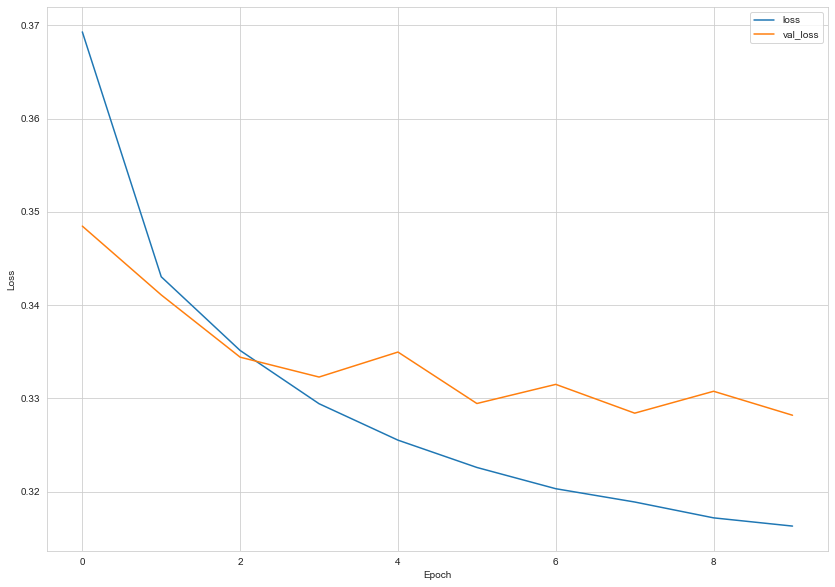

In [59]:
# lets see loss plot
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot(figsize=(14, 10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<h2 style="color:Peru;"> Prediction </h2>

In [60]:
predictions = model_nn.predict(X_test)

In [61]:
y_pred_nn = list(map(lambda x: np.argmax(x), predictions))

<h2 style="color:Peru;"> Result </h2>

In [62]:
print(f"Model Accuracy: {model_nn.evaluate(X_test, y_test, verbose=0)[1]}")

Model Accuracy: 0.8564897775650024


In [63]:
# roc_auc_score
print(f"Model roc_auc_score: {roc_auc_score(y_test, y_pred_nn)}")

Model roc_auc_score: 0.7400566551970378


In [64]:
# print(f"f1 score: {f1_score(y_test,y_pred_nn)}")

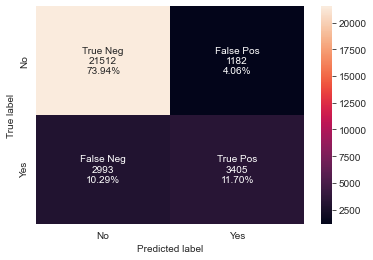

In [65]:
#confusion matrix
make_confusion_matrix(y_test,y_pred_nn)

In [66]:
# classification report
print(f"Classification Report:\n {classification_report(y_test,y_pred_nn)}")

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     22694
           1       0.74      0.53      0.62      6398

    accuracy                           0.86     29092
   macro avg       0.81      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092

